In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

# import tensorflow as tf

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# import tensorflow.keras.backend as k
# from tensorflow.keras.metrics import AUC

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

# from packaging import version
# from tensorflow.python.client import device_lib

# for BERT tokenization
# from transformers import BertTokenizer, TFAutoModel

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE

import joblib


In [2]:
# print("This notebook requires TensorFlow 2.0 or above")
# print("TensorFlow version: ", tf.__version__)
# assert version.parse(tf.__version__).release[0] >=2

# from tensorflow.python.client import device_lib
# tf.config.list_physical_devices('GPU')

# device_lib.list_local_devices()

In [3]:



# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [5]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


<Axes: ylabel='Commodity'>

19720

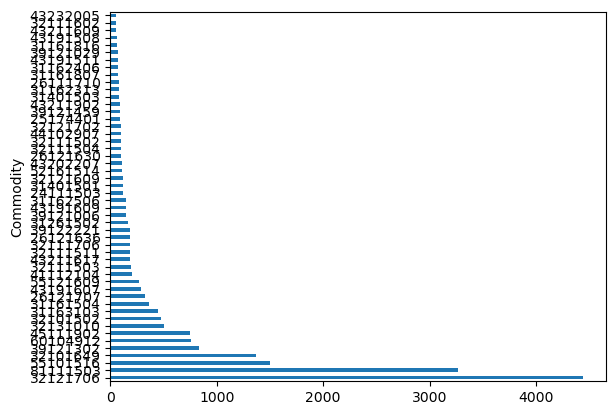

In [6]:
# can we get a dataframe of the top 50 Commodity CODES?
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [7]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])
# y_decoded = label_encoder.inverse_transform(y_encoded)

# Use one hot encoder to encode the Family CODES
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = one_hot_encoder.fit_transform(df7[['Commodity']])
# y_one_hot_decoded = one_hot_encoder.inverse_transform(y_one_hot_encoded)


In [8]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df7['Product_Description'])
X.shape


(19720, 24064)

In [9]:
tfidf_vectors = tfidf_vectorizer.inverse_transform(X)
df7['TF-IDF'] = list(tfidf_vectors)
df7 


,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,TF-IDF
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,"[ccx600, for, sheet, up, set]"
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[cf, ohm, 270, res, 004, 1000]"
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[200, 005, cf, ohm, res, 1000]"
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[56k, 06, cf, res, 1000]"
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[100k, 075, cf, res, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,"[14f, z462358, 36k, 0402, 16w, lf]"
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,"[42f, z462358, 510k, ohms, 0402, 16w, res]"
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,"[04f, z468610, 025pf, c0g, 15pf, 0201, lf, 50v]"
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,"[actuated, z480086, 01f, 16n, side, smd]"


In [10]:
# create training, validation, and testing sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)


In [11]:
# convert the true labels from one-hot encoded format to class labels
y_test_labels = label_encoder.inverse_transform(y_test_enc)

In [12]:
# create the SMOTE object
smote = SMOTE()

# fit and apply SMOTE to the training data
X_train_smote_enc, y_train_smote_enc = smote.fit_resample(X_train_enc, y_train_enc)

# print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_enc.shape)
print('Shape of y_train_smote:', y_train_smote_enc.shape)


Shape of X_train_count_smote: (181950, 24064)
Shape of y_train_smote: (181950,)


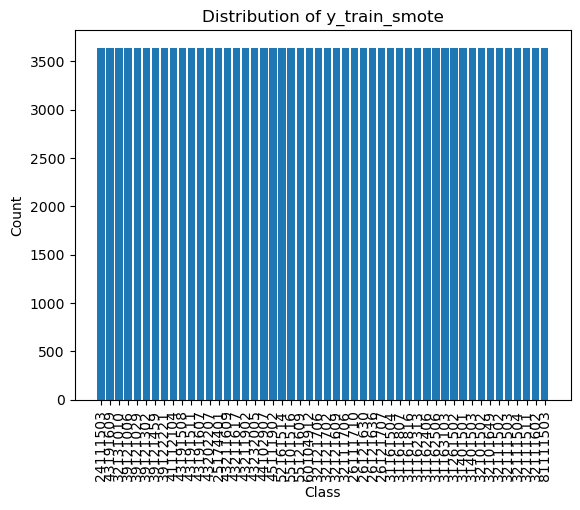

In [13]:
# create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder.inverse_transform(y_train_smote_enc), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [16]:
# create the XGBClassifier object
xgb = XGBClassifier(objective='multi:softmax', num_class=50, n_jobs=-1)


In [17]:
eval_set = [(X_val_enc, y_val_enc)]

# fit the model to the training data
xgb.fit(X_train_smote_enc, y_train_smote_enc, eval_set=eval_set, 
        early_stopping_rounds=5, verbose=True)



[0]	validation_0-mlogloss:0.94708
[1]	validation_0-mlogloss:0.67210
[2]	validation_0-mlogloss:0.63553
[3]	validation_0-mlogloss:0.54810
[4]	validation_0-mlogloss:0.51203
[5]	validation_0-mlogloss:0.47823
[6]	validation_0-mlogloss:0.45057
[7]	validation_0-mlogloss:0.41787
[8]	validation_0-mlogloss:0.39565
[9]	validation_0-mlogloss:0.37533
[10]	validation_0-mlogloss:0.36015
[11]	validation_0-mlogloss:0.34582
[12]	validation_0-mlogloss:0.33442
[13]	validation_0-mlogloss:0.32452
[14]	validation_0-mlogloss:0.31556
[15]	validation_0-mlogloss:0.30737
[16]	validation_0-mlogloss:0.30187
[17]	validation_0-mlogloss:0.29744
[18]	validation_0-mlogloss:0.29373
[19]	validation_0-mlogloss:0.29034
[20]	validation_0-mlogloss:0.28784
[21]	validation_0-mlogloss:0.28405
[22]	validation_0-mlogloss:0.28151
[23]	validation_0-mlogloss:0.27961
[24]	validation_0-mlogloss:0.27740
[25]	validation_0-mlogloss:0.27631
[26]	validation_0-mlogloss:0.27538
[27]	validation_0-mlogloss:0.27345
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_class=50, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [18]:
# Save the model to a file
joblib.dump(xgb, 'xgb_model.pkl')

pred_xgb = xgb.predict(X_test_enc)
pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
print_validation_report(y_test_labels, pred_xgb_decoded)


['xgb_model.pkl']

Classification Report
              precision    recall  f1-score   support

    24111503       0.91      0.91      0.91        11
    25174401       1.00      0.83      0.91         6
    26111710       0.80      0.80      0.80         5
    26121630       0.60      0.60      0.60        10
    26121636       1.00      0.93      0.96        14
    26121707       0.96      0.89      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       0.91      0.83      0.87        12
    31161816       1.00      0.89      0.94         9
    31162313       0.75      1.00      0.86         6
    31162406       0.80      0.80      0.80        10
    31162506       0.87      0.93      0.90        14
    31163103       1.00      0.98      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.88      0.88      0.88         8
    32101502       0.89      1.00      0.94        50
    3

In [20]:
# Load the saved model
xgb_model = joblib.load('xgb_model.pkl')

# Use the loaded model to make predictions on new data
pred_xgb = xgb_model.predict(X_test_enc)
pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
print_validation_report(y_test_labels, pred_xgb_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.91      0.91      0.91        11
    25174401       1.00      0.83      0.91         6
    26111710       0.80      0.80      0.80         5
    26121630       0.60      0.60      0.60        10
    26121636       1.00      0.93      0.96        14
    26121707       0.96      0.89      0.93        28
    31161504       1.00      0.98      0.99        53
    31161807       0.91      0.83      0.87        12
    31161816       1.00      0.89      0.94         9
    31162313       0.75      1.00      0.86         6
    31162406       0.80      0.80      0.80        10
    31162506       0.87      0.93      0.90        14
    31163103       1.00      0.98      0.99        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.88      0.88      0.88         8
    32101502       0.89      1.00      0.94        50
    3

In [20]:
# # create the XGBClassifier object
# xgb_cuda = XGBClassifier(objective='multi:softmax', num_class=50, tree_method='gpu_hist', verbose=True)
# # xgb_cuda = XGBClassifier(objective='multi:softmax', num_class=50, tree_method='auto')
# # xgb_cuda = XGBClassifier(tree_method='gpu_hist', verbose=True)


In [21]:
# eval_set = [(X_val_enc, y_val_enc)]

# # fit the model to the training data
# xgb_cuda.fit(X_train_smote_enc, y_train_smote_enc, eval_set=eval_set, early_stopping_rounds=None, verbose=True)
# # xgb_cuda.fit(X_train_smote_enc, y_train_smote_enc, early_stopping_rounds=None, verbose=True)

# # Save the model to a file
# joblib.dump(xgb_cuda, 'xgb_cuda_model.pkl')


In [22]:
# pred_xgb_cuda = xgb_cuda.predict(X_test_enc)
# pred_xgb_cuda_decoded = label_encoder.inverse_transform(pred_xgb_cuda)
# print_validation_report(y_test_labels, pred_xgb_cuda_decoded)


In [28]:
# create the XGBClassifier object
xgb_grid = XGBClassifier(objective='multi:softmax', num_class=50, n_jobs=-1)

# define the hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.2, 0.3, 0.4],
    # 'max_depth': [6],
    # 'subsample': [1],
    # 'colsample_bytree': [1],
    # 'gamma': [0],
    # 'reg_alpha': [1],
    # 'reg_lambda': [1],
    # 'scale_pos_weight': [1]
}

# create the GridSearchCV object
grid_search_xgb = GridSearchCV(xgb_grid, param_grid_xgb, cv=3, verbose=3)


In [29]:
eval_set_grid = [(X_val_enc, y_val_enc)]

# fit the GridSearchCV object on the training data
grid_search_xgb.fit(X_train_smote_enc, y_train_smote_enc, eval_set=eval_set_grid, early_stopping_rounds=5)

# create a XGBClassifier object with the best hyperparameters
xgb_best = grid_search_xgb.best_estimator_

# Save the model to a file
joblib.dump(xgb_best, 'xgb_best_model.pkl')


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[0]	validation_0-mlogloss:1.17721
[1]	validation_0-mlogloss:0.96161
[2]	validation_0-mlogloss:0.86016
[3]	validation_0-mlogloss:0.77848
[4]	validation_0-mlogloss:0.71390
[5]	validation_0-mlogloss:0.66273
[6]	validation_0-mlogloss:0.61710
[7]	validation_0-mlogloss:0.57522
[8]	validation_0-mlogloss:0.53949
[9]	validation_0-mlogloss:0.50862
[10]	validation_0-mlogloss:0.48052
[11]	validation_0-mlogloss:0.45766
[12]	validation_0-mlogloss:0.43559
[13]	validation_0-mlogloss:0.41549
[14]	validation_0-mlogloss:0.39903
[15]	validation_0-mlogloss:0.38390
[16]	validation_0-mlogloss:0.37075
[17]	validation_0-mlogloss:0.35840
[18]	validation_0-mlogloss:0.34751
[19]	validation_0-mlogloss:0.33746
[20]	validation_0-mlogloss:0.32851
[21]	validation_0-mlogloss:0.32051
[22]	validation_0-mlogloss:0.31398
[23]	validation_0-mlogloss:0.30794
[24]	validation_0-mlogloss:0.30197
[25]	validation_0-mlogloss:0.29709
[26]	validation_0-mlogloss:0.29248
[27]	

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1, num_class=50,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', ...),
             param_grid={'learning_rate': [0.2, 0.3, 0.4],
                         'n_estimators': [100, 200]},
             verbose=3)

['xgb_best_model.pkl']

In [30]:
# evaluate the model on the testing data
accuracy_xgb_best = xgb_best.score(X_test_enc, y_test_enc)
print('Test accuracy with best hyperparameters:', accuracy_xgb_best)

# print the best hyperparameters
print('Best hyperparameters:', grid_search_xgb.best_params_)


Test accuracy with best hyperparameters: 0.9452332657200812
Best hyperparameters: {'learning_rate': 0.2, 'n_estimators': 100}


In [31]:
# make predictions on the testing data
pred_xgb_best = xgb_best.predict(X_test_enc)
pred_xgb_best_decoded = label_encoder.inverse_transform(pred_xgb_best)
print_validation_report(y_test_labels, pred_xgb_best_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.91      0.91      0.91        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       1.00      0.50      0.67        10
    26121636       1.00      1.00      1.00        14
    26121707       0.93      0.96      0.95        28
    31161504       1.00      0.98      0.99        53
    31161807       0.91      0.83      0.87        12
    31161816       1.00      0.89      0.94         9
    31162313       0.75      1.00      0.86         6
    31162406       0.80      0.80      0.80        10
    31162506       0.93      0.93      0.93        14
    31163103       1.00      0.96      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.88      0.88      0.88         8
    32101502       0.93      1.00      0.96        50
    3